In [ ]:
# # 데이터 압축 풀기
# !tar -xvJf /workspace/mvtec_anomaly_detection.tar.xz -C /workspace/data/MVTecAD

# **0. 기본 설정**

In [1]:
import os
import random
import numpy as np
import torch

In [2]:
import sys
sys.path.append(os.path.abspath("..")) # 상위 폴더 모듈 import

In [3]:
### 재현성을 위한 시드 설정
def torch_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # multi-GPU 
    
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

In [4]:
torch_seed(42)

In [5]:
from easydict import EasyDict
from tqdm import tqdm
import pandas as pd

from patchcore.model import PatchCore
from datasets.factory import create_dataset
from torch.utils.data import DataLoader

In [6]:
## 실험 설정

args = EasyDict(dict(
    backbone="wide_resnet50_2", # feature extractor
    img_size=224,
    device="cuda:0",
    batch_train=32,
    batch_test=8,
))

In [7]:
## 모델
# PatchCore(백본/전처리/임베딩 파이프라인 활용)

model = PatchCore(
    backbone=args.backbone,
    faiss_on_gpu=True, 
    faiss_num_workers=4,
    sampling_ratio=0.1,
    device=args.device,
    input_shape=(3, args.img_size, args.img_size) # (3, 224, 224)
)

# **1. 데이터 준비**

In [8]:
## 데이터 경로

from pathlib import Path

# 절대 경로(환경에 맞게 조정)
DATA_ROOT = "/workspace/data"  

In [9]:
## 실험 재현성 보장

def _seed_worker(worker_id):
    import numpy as _np, random as _rd, torch as _th
    
    s = 42 + worker_id
    
    _np.random.seed(s)
    _rd.seed(s)
    _th.manual_seed(s)

In [10]:
def create_dataloader(class_name, img_size=args.img_size, data_root=DATA_ROOT,
                      num_workers=4, pin_memory=True):
    
    assert Path(data_root).exists(), f"Data root not found: {data_root}"
    
    trainset, testset = create_dataset(
        dataset_name="MVTecAD", # 사용할 데이터셋
        datadir=data_root, # 최상위 데이터 경로
        class_name=class_name, # 현재 대상 클래스(ex. bottle)
        img_size=img_size, # 이미지 크기
        mean=[0.485,0.456,0.406], 
        std=[0.229,0.224,0.225],
        aug_info=["Resize"],
        baseline=True,
        anomaly_ratio=0.0, # 정상 이미지만 활용
    )
    
    assert len(trainset)>0, f"No train samples for {class_name}"
    assert len(testset)>0,  f"No test samples for {class_name}"
    
    g = torch.Generator().manual_seed(42) # 시드 고정
    tr = DataLoader(trainset, batch_size=args.batch_train, shuffle=True, 
                    num_workers=num_workers, pin_memory=pin_memory,
                    worker_init_fn=_seed_worker, generator=g,
                    persistent_workers=(num_workers>0)
                    )
    te = DataLoader(testset,  batch_size=args.batch_test, shuffle=False,
                    num_workers=num_workers, pin_memory=pin_memory,
                    worker_init_fn=_seed_worker, generator=g,
                    persistent_workers=(num_workers>0))
    
    return tr, te

# **2. Patch Embedding 추출**

In [11]:
import torch.nn.functional as F

In [12]:
@torch.inference_mode()
def _embed_batch(images):
    """
    PatchCore 파이프라인
    - feature_aggregator → patchify(+spatial) → 해상도 정렬(보간) → preprocessing → preadapt_aggregator
    - 항상 (N, D_fixed) float32 ndarray를 반환
    """
    model.eval()
    device = args.device
    
    
    ## 레이아웃/타입 최적화
    x = images.contiguous(memory_format=torch.channels_last).to(device, non_blocking=True)
    if x.dtype != torch.float32:
        x = x.float()


    ## 1) 중간 레이어 특징 추출
    feat_agg = model.forward_modules["feature_aggregator"].eval()
    feats_dict = feat_agg(x)  # {'layer2': (B,512,28,28), 'layer3': (B,1024,14,14) ...}


    ## 2) 사용할 레이어만 선택 (보통 ['layer2','layer3'])
    feats = [feats_dict[layer] for layer in model.layers_to_extract_from]


    ## 3) 패치화 + 공간 크기 정보
    # 각 요소: (patched, patch_shape)
    # patched: (B, P, C, k, k),  patch_shape: [Hp, Wp]  (예: [28,28], [14,14])
    patched_with_info = [model.patch_maker.patchify(f, return_spatial_info=True) for f in feats]
    patch_shapes = [p[1] for p in patched_with_info] # [[Hp1,Wp1], [Hp2,Wp2], ...]
    patched = [p[0] for p in patched_with_info]      # list of (B,P,C,k,k)


    ## 4) 첫 레이어의 패치 그리드를 기준(레퍼런스)으로 맞춤
    ref_Hp, ref_Wp = patch_shapes[0] # 예: 28, 28
                               
    for i in range(1, len(patched)):
        _x = patched[i] # (B, P, C, k, k)                                       
        Hp_i, Wp_i = patch_shapes[i]

        # (B,P,C,k,k) → (B,Hp_i,Wp_i,C,k,k)
        _x = _x.reshape(_x.shape[0], Hp_i, Wp_i, *_x.shape[2:]) # (batch)*(grid)로 복원
        # → (B,C,k,k,Hp_i,Wp_i)
        _x = _x.permute(0, 3, 4, 5, 1, 2).contiguous()
        base_shape = _x.shape                      

        # → (B*C*k*k, Hp_i, Wp_i)
        _x = _x.reshape(-1, Hp_i, Wp_i)
        
        # bilinear 보간 → (ref_Hp, ref_Wp)
        _x = F.interpolate(_x.unsqueeze(1), size=(ref_Hp, ref_Wp),
                           mode="bilinear", align_corners=False).squeeze(1)
        
        # 복원
        _x = _x.reshape(*base_shape[:-2], ref_Hp, ref_Wp) # (B, C, k, k, ref_Hp, ref_Wp)
        _x = _x.permute(0, 4, 5, 1, 2, 3).contiguous() # (B, ref_Hp, ref_Wp, C, k, k)
        _x = _x.reshape(_x.shape[0], ref_Hp*ref_Wp, *_x.shape[3:]) # (B, ref_Hp*ref_Wp, C, k, k)
        patched[i] = _x


    ## 5) (B,P,C,k,k) 리스트 → (B*P, C, k, k) 리스트
    patched_flat = [p.reshape(-1, *p.shape[-3:]).contiguous() for p in patched]


    ## 6) preprocessing(정규화 등) → (N, D_fixed) torch.Tensor
    proc = model.forward_modules["preprocessing"](patched_flat)
    out  = model.forward_modules["preadapt_aggregator"](proc)


    ## 7) 안전 변환(동기화 → CPU → numpy float32)
    if out.is_cuda:
        torch.cuda.synchronize()
    out = out.detach().contiguous().to("cpu").numpy().astype(np.float32, copy=False)
    
    
    ## 8) 2D 보장
    if out.ndim == 1:
        out = out.reshape(1, -1)
    elif out.ndim > 2:
        out = out.reshape(-1, out.shape[-1])
    return out

In [13]:
def collect_train_test_normals(class_name, max_patches_per_img=0):
    """
    train-normal vs test-normal 패치 임베딩 모음 (np.ndarray, np.ndarray)
    """
    ## 데이터 준비(dataloader 선언)
    tr_loader, te_loader = create_dataloader(class_name)

    def cap(X, k, seed):
        if k<=0 or X.size==0: 
            return X
        n = min(k, len(X))
        idx = np.random.default_rng(seed).choice(len(X), n, replace=False)
        return X[idx]
    
    
    ## train normal 
    # trainloader는 normal만
    train_feats = []
    for batch in tqdm(tr_loader, desc=f"{class_name} train(normal)"):
        imgs = batch[0]  # (imgs, labels, cls_labels) 형태
        X = _embed_batch(imgs)
        
        if max_patches_per_img > 0:
            X = cap(X, max_patches_per_img * len(imgs), seed=0)
        if X.size > 0:
            train_feats.append(X)
            
    if len(train_feats) == 0:
        raise ValueError(f"[{class_name}] no train-normal features extracted.")
    Xtrain = np.concatenate(train_feats, axis=0).astype(np.float32, copy=False)


    ## test normal
    # testloader엔 이상이 섞임 → 정상만 필터링
    test_feats = []
    for batch in tqdm(te_loader, desc=f"{class_name} test(normal+abnormal)"):
        imgs = batch[0]
        labels = batch[1]
        
        # 정상(0) 마스크
        if hasattr(labels, "numpy") or hasattr(labels, "cpu"):
            mask = (labels == 0)
        else:
            mask = np.array(labels) == 0
        if mask.sum() == 0:
            continue
        
        imgs_norm = imgs[mask]
        X = _embed_batch(imgs_norm)
        
        if max_patches_per_img > 0:
            X = cap(X, max_patches_per_img * int(mask.sum()), seed=1)
        if X.size > 0:
            test_feats.append(X)
    
    if len(test_feats) == 0:
        raise ValueError(f"[{class_name}] no test-normal features found.")
    
    Xtest = np.concatenate(test_feats, axis=0).astype(np.float32, copy=False)

    return Xtrain, Xtest

# **3. 분포 차이 측정**

In [14]:
from sklearn.covariance import LedoitWolf # 공분산 행렬 추정

## **3-1. 정량적 지표**

In [15]:
def subsample(X, max_n = 4000, seed = 0):
    if len(X) <= max_n: 
        return X
    rng = np.random.default_rng(seed)
    
    return X[rng.choice(len(X), max_n, replace=False)]

In [16]:
def standardize_by(X, Y):
    mu = X.mean(0)
    sd = X.std(0) + 1e-6
    
    return (X-mu)/sd, (Y-mu)/sd

In [17]:
def mmd_rbf(X,Y, gammas=(0.5,1,2)):
    def k(A,B,g):
        A2 = (A**2).sum(1)[:,None]
        B2 = (B**2).sum(1)[None,:]
        d2 = A2 + B2 - 2*A@B.T
        return np.exp(-g*d2)
    
    m, n = len(X), len(Y)
    if m<2 or n<2: 
        return float("nan")
    
    val = 0.
    # 분모가 0이 되는 상황 방지
    denom_x = max(m*(m-1), 1)
    denom_y = max(n*(n-1), 1)
    
    for g in gammas:
        Kxx = k(X,X,g)
        Kyy = k(Y,Y,g)
        Kxy = k(X,Y,g)
        val += (Kxx.sum()-np.trace(Kxx))/denom_x + (Kyy.sum()-np.trace(Kyy))/denom_y - 2*Kxy.mean()
    
    return float(val/len(gammas))

In [18]:
def fid_like(X, Y):
    mu1, mu2 = X.mean(0), Y.mean(0)
    
    try:
        S1 = LedoitWolf().fit(X).covariance_
        S2 = LedoitWolf().fit(Y).covariance_
    except Exception:
        # fallback: diag 공분산
        S1 = np.diag(X.var(0) + 1e-6)
        S2 = np.diag(Y.var(0) + 1e-6)
    
    s = np.linalg.svd(S1@S2, compute_uv=False)
    tr_sqrt = np.sum(np.sqrt(np.abs(s)))
    
    return float(np.sum((mu1 - mu2)**2) + np.trace(S1 + S2) - 2*tr_sqrt)


In [19]:
def compute_shift_metrics(train_feats, test_feats, max_n=4000):
    if len(train_feats)<2 or len(test_feats)<2:
        raise ValueError(f"Too few patches for metrics: train={len(train_feats)}, test={len(test_feats)}")
    
    X = subsample(train_feats, max_n)
    Y = subsample(test_feats, max_n)
    
    Xn,Yn = standardize_by(X,Y)
    
    return {"MMD": mmd_rbf(Xn,Yn), 
            "FID": fid_like(Xn,Yn)}

In [20]:
def to_zavg_table(metrics_dict):
    df = pd.DataFrame(metrics_dict).T
    
    for c in df.columns:
        df[c] = (df[c]-df[c].mean()) / (df[c].std() + 1e-12)
        
    df["D"] = df.mean(1)  # z-정규화 평균을 종합 지수 D로 사용
    
    return df

## **3-2. 시각화(정성적 지표)**

### **t-SNE**

In [21]:
import matplotlib.pyplot as plt

import cupy as cp
from cuml.manifold import TSNE as cuTSNE

from sklearn.manifold import TSNE as skTSNE

In [22]:
def tsne_plot(X, Y, title="", perpl=30, save=None, seed=0):
    Z = np.concatenate([X, Y], 0).astype(np.float32, copy=False)
    lab = np.array([0]*len(X) + [1]*len(Y)) # 0: train normal, 1: test normal
    
    # perplexity 조정
    N = len(Z)
    perpl = min(perpl, max(3, N//3))
    
    if N < 4:
        raise ValueError(f"t-SNE requires at least 4 samples, got N={N}")
    
    
    ## 1) 먼저 cuML 시도 (GPU), 실패 시 sklearn (CPU)로 안전 폴백
    try:
        dev = torch.cuda.current_device() if torch.cuda.is_available() else 0
        try: 
            cp.cuda.Device(dev).use()
        except: 
            pass
        Zg = cp.asarray(Z)
        ts_g = cuTSNE(
            n_components=2,
            perplexity=float(perpl),
            learning_rate=200,    # cuML은 숫자만 허용
            random_state=seed,
            verbose=0,
        ).fit_transform(Zg)
        ts = cp.asnumpy(ts_g)
        backend = "cuML"
    
    
    ## 2) 실패 시 sklearn (CPU)로 안전 폴백
    except Exception:
        ts = skTSNE(n_components=2, 
                    perplexity=perpl,
                    init="random", 
                    random_state=seed
                   ).fit_transform(Z)
        backend = "sklearn"
        
        
    ## 3) 시각화
    plt.figure(figsize=(5,4))
    
    plt.scatter(ts[lab==0,0], ts[lab==0,1], s=6, alpha=.6, label="train normal")
    plt.scatter(ts[lab==1,0], ts[lab==1,1], s=6, alpha=.6, label="test normal")
    
    plt.title(f"{title}  [{backend}]")
    plt.legend()
    plt.tight_layout()
    
    if save:
        plt.savefig(save, dpi=200)
        plt.close(); return
    
    plt.show()

### **UMAP**

In [23]:
import umap

In [24]:
def umap_plot(X, Y, title="", save=None, seed=0):
    
    Z = np.concatenate([X,Y],0)
    lab = np.array([0]*len(X)+[1]*len(Y))
    U = umap.UMAP(n_components = 2, 
                  random_state = seed).fit_transform(Z)
    
    plt.figure(figsize = (5,4))
    plt.scatter(U[lab==0,0], U[lab==0,1], s=6, alpha=.6, label="train normal")
    plt.scatter(U[lab==1,0], U[lab==1,1], s=6, alpha=.6, label="test normal")
    
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    
    if save: 
        plt.savefig(save, dpi=200)
        plt.close()
        return
    
    plt.show()

# **4. 테스트**

## **4-1. 한 클래스 먼저(샘플)**

In [25]:
import os, gc

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # 동기식 실행 활성화
torch.cuda.empty_cache()  # GPU 메모리 정리

In [26]:
target_cls = "hazelnut"

In [27]:
# 정량: 원본 차원 기준(패치 전부 사용하려면 max_patches_per_img=0)
Xtr, Xte = collect_train_test_normals(target_cls, max_patches_per_img=0)

print("train patches:", len(Xtr), "test patches:", len(Xte))

hazelnut train(normal):   0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/envs/patchcore/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/envs/patchcore/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResi

train patches: 306544 test patches: 31360


In [28]:
print("metrics:", compute_shift_metrics(Xtr, Xte))

metrics: {'MMD': 1.165045493097997e-09, 'FID': 77.6463623046875}


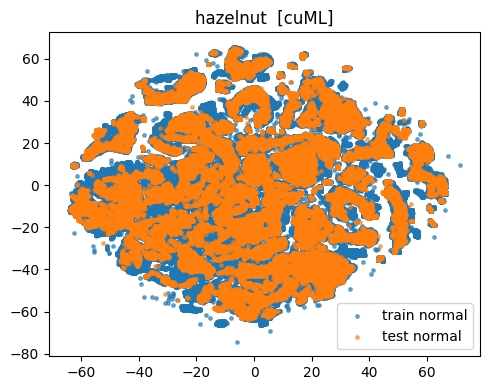

In [29]:
# 정성: 이미지 단위
tsne_plot(Xtr, Xte, title=f"{target_cls}")

In [30]:
umap_plot(Xtr, Xte, title=f"{target_cls} UMAP")

/opt/conda/envs/patchcore/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## **4-2. 전체 실행**